In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler


In [2]:
data_dir = './Leagues'
files = [
    'all_players_stats',
    'all_players_values',
    'all_players_stats_details',
    
    'all_teams_values',
    'all_teams_stats'
]

In [3]:
players_stats = pd.read_csv(f'{data_dir}/all_players_stats.csv')
players_values = pd.read_csv(f'{data_dir}/all_players_values.csv')
players_details = pd.read_csv(f'{data_dir}/all_players_stats_details.csv')

teams_stats = pd.read_csv(f'{data_dir}/all_teams_stats.csv')
teams_values = pd.read_csv(f'{data_dir}/all_teams_values.csv')

In [4]:
top_teams_per_league = teams_stats.groupby('League').apply(lambda x: x.nlargest(3, 'Pts')).reset_index(drop=True)
top_player_stats = players_stats[players_stats['team_name'].isin(top_teams_per_league['team_name'])]

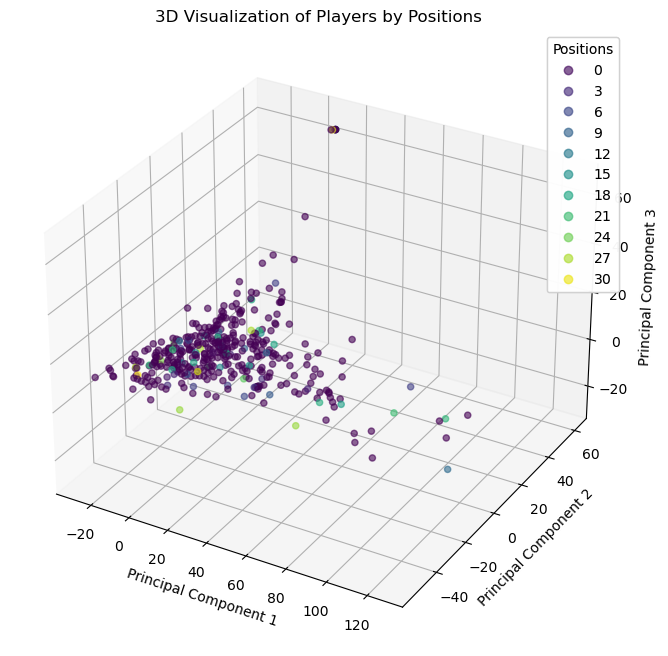

In [6]:
# 불필요한 컬럼 제거
columns_to_exclude = ['Apps', 'Mins']
filtered_columns = [col for col in top_player_stats.columns if col not in columns_to_exclude]
top_player_stats_filtered = top_player_stats[filtered_columns].copy()

# NaN 값 처리: 숫자형 컬럼에 대해 평균으로 대체
for column in top_player_stats_filtered.select_dtypes(include=[np.number]).columns:
    mean_val = top_player_stats_filtered[column].mean()
    top_player_stats_filtered[column].fillna(mean_val, inplace=True)

# PCA로 차원 축소 (3차원)
pca = PCA(n_components=3)  # 3차원으로 축소
player_stats_pca = pca.fit_transform(top_player_stats_filtered.select_dtypes(include=[np.number]))

# PCA 결과를 DataFrame으로 변환
pca_df = pd.DataFrame(data = player_stats_pca, columns = ['PC1', 'PC2', 'PC3'])
pca_df['position'] = top_player_stats['position']  # 포지션 정보 추가

# 3차원 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['position'].astype('category').cat.codes, cmap='viridis', alpha=0.6)
legend = ax.legend(*scatter.legend_elements(), title="Positions")
ax.add_artist(legend)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Visualization of Players by Positions')
plt.show()